<a href="https://colab.research.google.com/github/JumpyB/Projects-analysis/blob/main/Project_Mobile_game_AB_test_%26_Player_Retention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math
import scipy.stats as stats

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Project Background

Cookie Cats is a widely popular mobile puzzle game developed by Tactile Entertainment. It is a classic "Match-3" type game, where players must connect blocks of the same color to perform an elimination, thereby clearing the board and passing the level. A major feature of the game is the inclusion of singing cats.

As players advance through the game, they encounter **"gates"** that restrict progress, requiring them to either wait a significant period or make a purchase to continue. Beyond their monetization potential, these gates function as a mechanism to enforce breaks, theoretically preventing burnout and prolonging long-term engagement.

The critical question addressed here is optimization: Where is the best location for these gates?

This project evaluates an A/B test comparing the original gate placement at level 30 against a test variation at level 40, specifically analyzing the effect this shift has on player retention.


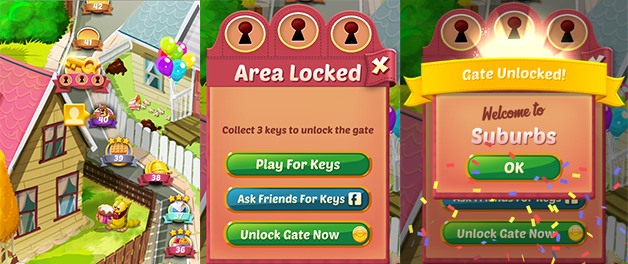

# Part 2: Explore the Data (EDA)


## 2.1 Load the A/B Testing Data

In [ ]:
df= pd.read_excel('/content/drive/MyDrive/DA-Project/cookie_cats.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2.2 Check any missing value

In [ ]:

df.isnull().sum()

,0
userid,0
version,0
sum_gamerounds,0
retention_1,0
retention_7,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


## 2.3 Analyse the player activity

In [ ]:
df.groupby('version').count().reset_index()

,version,userid,sum_gamerounds,retention_1,retention_7
0,gate_30,44700,44700,44700,44700
1,gate_40,45489,45489,45489,45489


For the control (gate_30) group and the test (gate_40) group, numbers are pretty close.

/tmp/ipython-input-3393796008.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['sum_gamerounds'])


<Axes: xlabel='sum_gamerounds', ylabel='Density'>

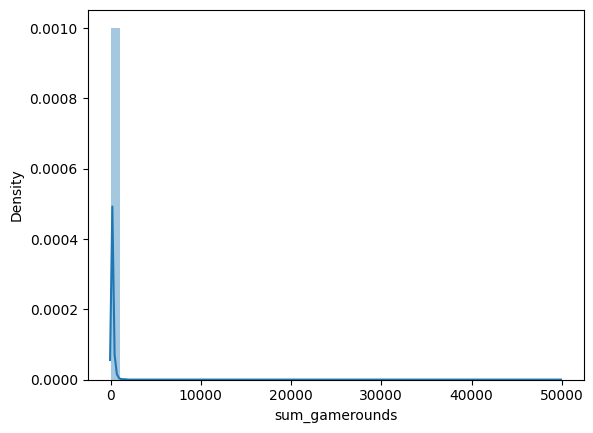

In [ ]:
sns.distplot(df['sum_gamerounds'])

In [ ]:
number_df = df.groupby('sum_gamerounds')['userid'].count().reset_index()
number_df.rename(columns={'userid': 'counts'}, inplace=True)
number_df

,sum_gamerounds,counts
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
937,2294,1
938,2438,1
939,2640,1
940,2961,1


From the graph above, we can tell that

**1. Extreme Right Skew**

The distribution is heavily right-skewed (positive skew). The vast majority of values are clustered near zero, with a very long tail extending out to ~50,000.

**2. Most Users Play Very Few Rounds**
The density spike near 0 is extremely tall (peak ~0.0010), meaning the median and mode are likely very low — most players play only a handful of game rounds total.

**3. Potential Data Quality Check**
The values near/at 0 deserve scrutiny — these could represent users who installed but never played, which is common in mobile gaming datasets (churned immediately or are test accounts).







There may be reasons why players play only 1 or 2 rounds of games:

*   They download the game and find out it is different from what they thought.
*   They do not find the game is interesting.
*   The game is too easy so they get bored quickly.
*   The game gets too difficult then they give up soon.

    .......


<Axes: xlabel='version', ylabel='sum_gamerounds'>

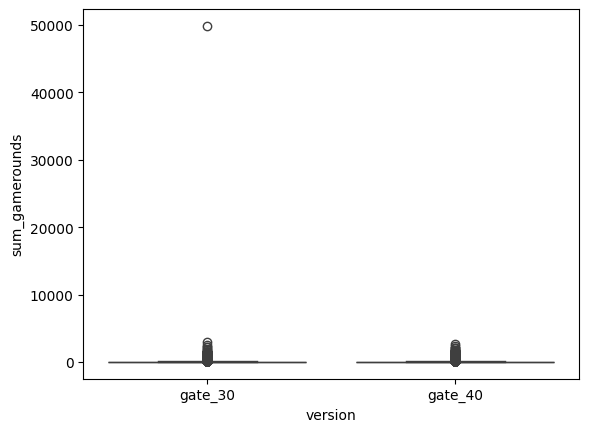

In [ ]:
sns.boxplot(x='version', y='sum_gamerounds', data=df)

In [ ]:
# Drop the outlier
df.sort_values(by='sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True


In [ ]:
df_sorted = df.sort_values(by='sum_gamerounds', ascending=False)
df = df_sorted.drop(df_sorted.index[0])
df.sort_values(by='sum_gamerounds', ascending=False).head()

,userid,version,sum_gamerounds,retention_1,retention_7
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
46344,5133952,gate_30,2251,True,True


<Axes: xlabel='version', ylabel='sum_gamerounds'>

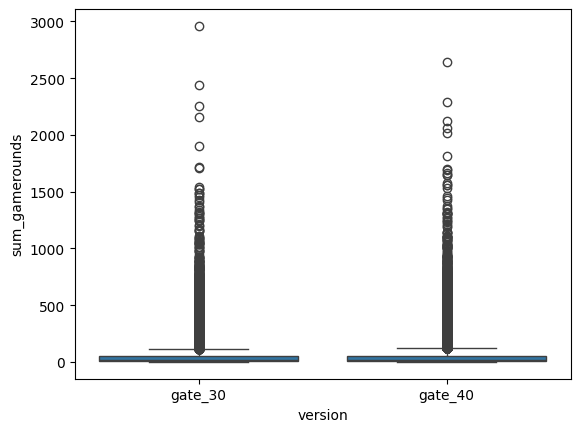

In [ ]:
sns.boxplot(x='version', y='sum_gamerounds', data=df)

In [ ]:
df.describe()

,userid,sum_gamerounds
count,9.018800e+04,90188.000000
mean,4.998397e+06,51.320253
std,2.883298e+06,102.682719
min,1.160000e+02,0.000000
25%,2.512211e+06,5.000000
50%,4.995804e+06,16.000000
75%,7.496461e+06,51.000000
max,9.999861e+06,2961.000000


In [ ]:
upper_limit = df['sum_gamerounds'].quantile(0.99)

df_filtered = df[df['sum_gamerounds'] < upper_limit]
df_filtered.describe()

,userid,sum_gamerounds
count,8.928300e+04,89283.000000
mean,4.998198e+06,44.488088
std,2.883196e+06,71.705557
min,1.160000e+02,0.000000
25%,2.511391e+06,5.000000
50%,4.995075e+06,16.000000
75%,7.496177e+06,49.000000
max,9.999861e+06,492.000000


In [ ]:
# ax = sns.catplot(data=df_filtered, kind='box', x='version',y='sum_gamerounds',hue=None,
#                  col='retention_1', row='retention_7', height=4, palette='muted'
#                  )

In [ ]:
df_filtered.head()

,userid,version,sum_gamerounds,retention_1,retention_7
70818,7853429,gate_40,492,True,True
79708,8824912,gate_30,492,True,True
75344,8343478,gate_30,492,True,True
56134,6220878,gate_40,491,True,False
23787,2647964,gate_30,491,True,True


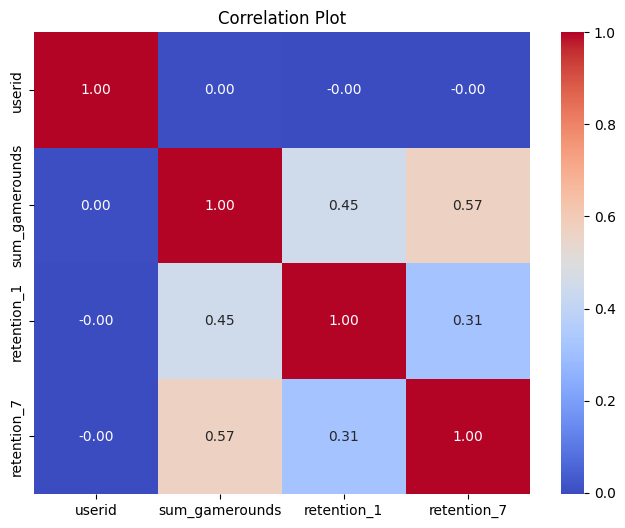

In [ ]:
corr_matrix = df_filtered.corr(numeric_only=True)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

Players in the control group seems to play more rounds of game compared to players in the test group.

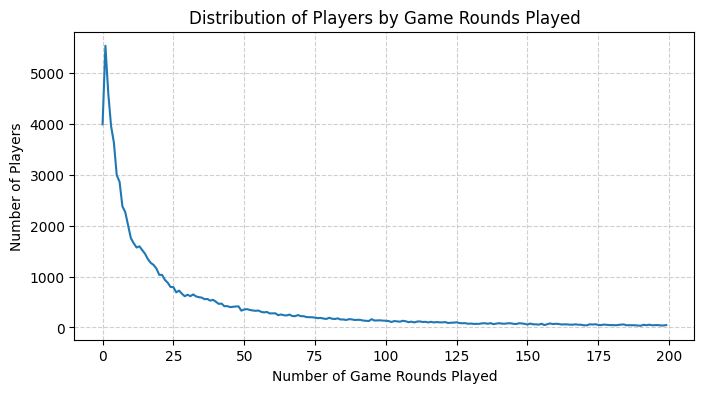

In [ ]:
plt.figure(figsize=(8, 4))

plt.plot(number_df['sum_gamerounds'][:200], number_df['counts'][:200])

plt.title('Distribution of Players by Game Rounds Played')
plt.xlabel('Number of Game Rounds Played')
plt.ylabel('Number of Players')

plt.grid(True, linestyle='--', alpha=0.6)

Text(0, 0.5, 'Number of Players')

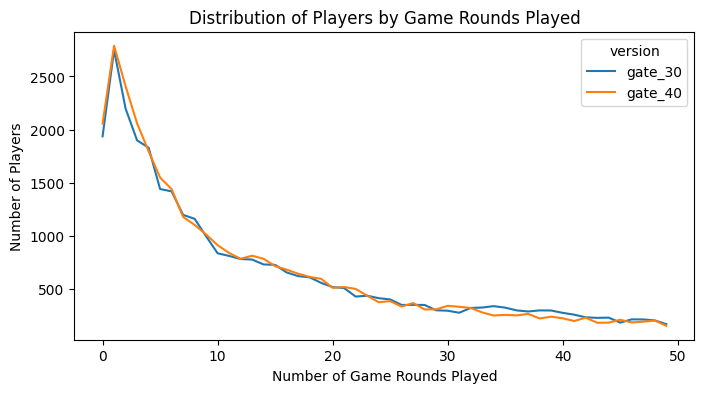

In [ ]:
ana_df = df.groupby(['sum_gamerounds', 'version'])['userid'].count().reset_index()
ana_df.rename(columns={'userid': 'counts'}, inplace=True)
ana_df = ana_df[:100]

plt.figure(figsize=(8,4))
sns.lineplot(data=ana_df, x='sum_gamerounds', y='counts', hue='version')

plt.title('Distribution of Players by Game Rounds Played')
plt.xlabel('Number of Game Rounds Played')
plt.ylabel('Number of Players')

Observation:

This is the typical mobile game engagement funnel: many players try the game but most quit very early.

The biggest opportunity isn't gate optimization — it's reducing early drop-off in the first 1–10 rounds, where the largest absolute number of players are being lost. Both versions suffer equally from this early churn problem.

## 2.4 Count the Retention Rate for each group

Having identified that nearly half of installs result in a return visit the following day, we can use this benchmark to evaluate the Day 1 retention split between our test groups.

**1-day retention** measures the percentage of players who return to the game the day after they first install/play it.

Formula: Players who came back on Day 1 ÷ Total players who installed × 100%

In [ ]:
# Count the retention rate for each group

df.groupby('version')[['retention_1', 'retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.448198,0.190183
gate_40,0.442283,0.182000




Gate_30 outperforms gate_40 on both retention rates, but the differences are small. For instance, Day 1 retention rate drops from 44.82% to 44.23% when the gate at level 30 moves gate_40.

We cannot tell from these numbers alone wherther the gap is real or just noise, so bootstapping is needed.

7-day retention rate difference is larger. It suggests that moving the gate the gate earlier may compound its positive effect over time. Players who encounter the gate at level 30 may be better primed for long-term engagement.

# Part 3: Comparing 1-day retention rate


In [ ]:
df.sample(frac = 1,replace = True).head()

,userid,version,sum_gamerounds,retention_1,retention_7
49709,5513122,gate_40,12,False,False
48147,5341383,gate_30,7,False,False
20542,2286162,gate_30,2,False,False
15357,1704951,gate_40,3,False,False
60060,6650712,gate_40,0,False,False


In [ ]:
df.sample(frac = 1, replace = True).groupby('version')[['retention_1', 'retention_7']].mean()

,retention_1,retention_7
version,,
gate_30,0.447016,0.190066
gate_40,0.444545,0.180318


**Bootstraping - Is difference significant?**

###3.1 Bootstraping for 1-day retention rate

In [ ]:
boot_list = []

for i in range(1000):
  boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_1'].mean()
  boot_list.append(boot_mean)


In [ ]:
boot_df = pd.DataFrame(boot_list)
boot_df.head()

version,gate_30,gate_40
retention_1,0.446118,0.445672
retention_1,0.448553,0.440072
retention_1,0.449544,0.446267
retention_1,0.453591,0.440180
retention_1,0.450010,0.446338


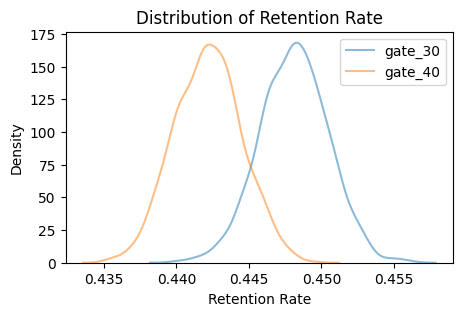

In [ ]:
plt.figure(figsize=(5, 3))

sns.kdeplot(boot_df['gate_30'], label='gate_30',  alpha=0.5)

sns.kdeplot(boot_df['gate_40'], label='gate_40',  alpha=0.5)

plt.title('Distribution of Retention Rate')
plt.xlabel('Retention Rate')
plt.ylabel('Density')
plt.legend()

The two bootstrapped distributions are clearly seperated with minimal overlaps, suggesting that the difference is real.
Though the gap between peaks is 0.6%, which is relatively small.

We can calculate the difference to ensure the significance of the difference.

Probability of gate_30's retention rate is greater than gate_40's retention rate is 0.971


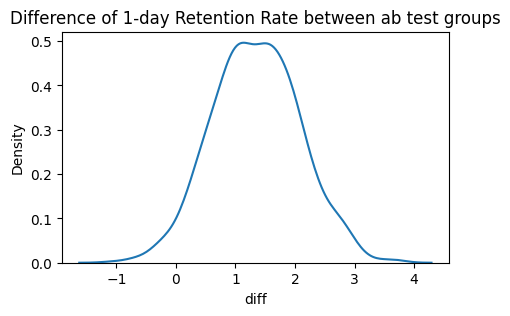

In [ ]:
boot_df['diff'] = (boot_df['gate_30'] - boot_df['gate_40'])/boot_df['gate_40']*100

plt.figure(figsize=(5, 3))
sns.kdeplot(boot_df['diff'])
plt.title('Difference of 1-day Retention Rate between ab test groups')

prob_30_greater_than_40 = (boot_df['diff']>0).mean()
print("Probability of gate_30's retention rate is greater than gate_40's retention rate is" ,prob_30_greater_than_40)

The 95.8% clearly shows it falls in the conventional 95% condidence threshold meaning that **the gate should be keep at level 30** since the difference is statistically significant.

### 3.2 Z-test for 1-day retention rate

$
H_0: p_{gate 30} >= p_{gate 40} \\
H_1: p_{gate 30} < p_{gate 40}
$

#### 3.2.1 Traditional Statistic method to get z-test result

In [ ]:
def z_test(p0, p1, n0, n1):
  se0 = math.sqrt(p0*(1-p0)/n0)
  se1 = math.sqrt(p1*(1-p1)/n1)
  z_score = (p1-p0)/math.sqrt(se0**2+se1**2)
  return z_score

In [ ]:
converted_player = df.groupby('version')['retention_1'].sum()
total_player = df.groupby('version')['userid'].count()

n0 = total_player['gate_30']
n1 = total_player['gate_40']
p0 = converted_player['gate_30']/total_player['gate_30']
p1 = converted_player['gate_40']/total_player['gate_40']

z_score = z_test(p0, p1, n0, n1)
print("Z-score is", z_score)

p_value = stats.norm.cdf(abs(z_score))
print("P-value is", p_value)

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. The later gate level is significantly better.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.")

Z-score is -1.787114623539207
P-value is 0.9630405177865647
Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.


**Because z-score is calculated as p1-p0 and the result is negative, which suggested that retention rate of gate_40 is worse than the retention rate of gate_30. <br>
P-value is larger than 0.05, also meaning fail to reject the null hypothesis.**

#### 3.2.2 Python function to get z-test result

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
count = [converted_player['gate_40'], converted_player['gate_30']]
nobs = [total_player['gate_40'], total_player['gate_30']]

# [treatment, control] to match the hypothesis H1: p_treatment > p_control
z_score, p_value = proportions_ztest(count, nobs, alternative='larger')

print("Z-score is", z_score)
print("P-value is", p_value)

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. The later gate level is significantly better.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.")

Z-score is -1.787103509763628
P-value is 0.9630396198290827
Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.


### 3.3 T-test for 1-day retention rate

#### 3.3.1 Traditional Statistic method to get t-test result

$
H_0: p_{gate 30} >= p_{gate 40} \\
H_1: p_{gate 30} < p_{gate 40}
$

In [ ]:
converted_old = df[df['version'] == 'gate_30']['retention_1']
converted_new = df[df['version'] == 'gate_40']['retention_1']

# Calculate the sample standard deviation
s0 = np.std(converted_old, ddof=1)
s1 = np.std(converted_new, ddof=1)

t_score = (p1-p0)/math.sqrt((s0**2/n0)+(s1**2/n1))
print("T-score is", t_score)

p_value = stats.t.cdf(abs(t_score), df=n0+n1-2)
print("P-value is", p_value)

T-score is -1.787094804723698
P-value is 0.963037237857946


In [ ]:
t_score, p_value = stats.ttest_ind(converted_new, converted_old, alternative='greater')
print("T-score is", t_score,"and", "P-value is", p_value)

T-score is -1.787115337299244 and P-value is 0.9630388968490874


#### 3.3.2 Python Function to get result

In [ ]:
t_score, p_value = stats.ttest_ind(converted_new, converted_old, alternative='greater')
print(t_score, p_value)

-1.787115337299244 0.9630388968490874


# Part 4: Comparing with 7-day Retention rate

**Critical context:**

Day 1 retention may not fully reflect the gate's true impact because most players haven't even reached level 30 yet after just one day.


By day 7, however, most players have progressed far enough to actually hit the gate - making 7-day retention bootstrap result will be even more meaningful signal for this specific experiment.

In [ ]:
df.groupby('version')['retention_7'].mean()

,retention_7
version,
gate_30,0.190183
gate_40,0.182000


**Why the gap is larger at Day 7?**


*   More players have enough time to reach the gate 30 or gate 40.
*   By Day 7, gate_40 players have now hit that wall, exprienced frustration, and churned - widening the gap.

Let us dig in the significance of difference between the AB groups by using bootstraping methods.


### 4.1 Bootstraping for 7-day retention rate

In [ ]:
df.sample(frac =1, replace = True).groupby('version')['retention_7'].mean()

,retention_7
version,
gate_30,0.189258
gate_40,0.182217


Text(0.5, 1.0, 'Difference of 7-day Retention Rate between ab test groups')

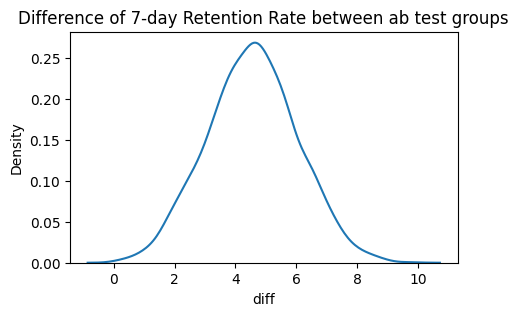

In [ ]:
boot_7d_list = []

for i in range(2000):
  boot_7d_mean = df.sample(frac =1, replace = True).groupby('version')['retention_7'].mean()
  boot_7d_list.append(boot_7d_mean)

boot_7d_df = pd.DataFrame(boot_7d_list)

boot_7d_df['diff'] = (boot_7d_df['gate_30'] - boot_7d_df['gate_40'])/boot_7d_df['gate_40'] * 100

plt.figure(figsize=(5, 3))
sns.kdeplot(boot_7d_df['diff'])
plt.title('Difference of 7-day Retention Rate between ab test groups')

In [ ]:
print("Probability of 7-day retention rate is larger at level 30 gate in the game is", (boot_7d_df['diff'] > 0).mean())

Probability of 7-day retention rate is larger at level 30 gate in the game is 1.0


**The bootstraping simulation shows the conclusion that the company should not move the gate level from 30 to 40 if the company would like to keep the higher retention rate of players both for 1-day or 7-day.** <br>
Probably because that passing the level that is easier will encourage people to keep on playing.

### 4.2 Z-test for 7-day retention rate

#### 4.2.1 Use traditional statistic method to get z-test result


The Hypothses

$
H_0: p_{gate30} >= p_{gate40}
\\
H_1: p_{gate30} < p_{gate40}
$



This is a one-tailed test asking: "Is gate_40 significantly better thant gate_30?"

In [ ]:
converted_player = df.groupby('version')['retention_7'].sum()
total_player = df.groupby('version')['userid'].count()

n0 = total_player['gate_30']
n1 = total_player['gate_40']
p0 = converted_player['gate_30']/total_player['gate_30']
p1 = converted_player['gate_40']/total_player['gate_40']

z_score = z_test(p0, p1, n0, n1)
print("Z-score is", z_score)

p_value = stats.norm.cdf(abs(z_score))
print("P-value is", p_value)

if p_value < 0.05:
    print("Conclusion: Reject the null hypothesis. The later gate level is significantly better.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.")

Z-score is -3.1571155010317264
P-value is 0.9992033089042881
Conclusion: Fail to reject the null hypothesis. There is not enough evidence that the later gate level is better.


#### 4.2.2 Use Python function to get z-test result


In [ ]:
converted_new = df[df['version'] == 'gate_40']['retention_7']
converted_old = df[df['version'] == 'gate_30']['retention_7']

In [ ]:
t_score, p_value = stats.ttest_ind(
    converted_new,   # gate_40
    converted_old,   # gate_30
    alternative='greater'  # testing if gate_40 > gate_30
)
print(t_score, p_value)


-3.1575495965685936 0.9992042321351072


The p-value of 0.9992 means there is a 99.92% probability against gate_40 being better. This is essentially the mirror image of what we found with bootstrapping.

# Part 5: Conclusion

Both the bootstrap and z-test converge on the same conclusion: gate_30 produces significantly better both 1-day retention and 7-day retention than gate_40. The recommendation is — **keep the gate at level 30**.

The data suggests a conterintuitive result that a later gate would not give players more freedom and improve the retention, likely due to:

*   **Players who play too long time with no interruption can cause dinimishing enjoyment**. A gate at level 30 actually is like a natural break point that keeps players wanting more rather than getting exhausted. This in known for **Hedonic Adaptation**.
*   By the time players who hit the gate_40 have invested more time and the interruption makes them feel more frustrating relative to early stage player  hitting gate_30, so gate_40 players are more likely to churn.



Addtional insights:

*   Monitor the rate, will the gate at level 30 convert more players to paying customers?
*   Find out the reason behind the high drop-off ratio in the first 10 game rounds. If there are no people engage in the games, then the retention rate will lack of meaning.
*   Consider testing putting the gate at level 20 to see if the hedonic adaptation effect holds even earlier.

......

**Always test assumptions to see what players want with evidence.**
Forcing players to stop at later seemed like the player-friendly choice, but the numbers show players engages more with earlier constraints.





